<a href="https://colab.research.google.com/github/slajan01/mnist2/blob/main/Kaggle_Digit_Recognizer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

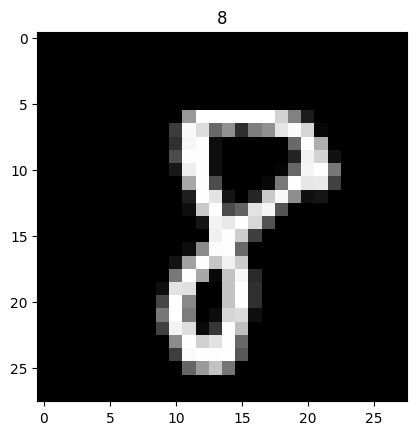

Epoch 1/25
945/945 ━━━━━━━━━━━━━━━━━━━━ 739s 779ms/step - accuracy: 0.8397 - loss: 0.7281 - val_accuracy: 0.9786 - val_loss: 0.0681 - learning_rate: 0.0010
Epoch 2/25
945/945 ━━━━━━━━━━━━━━━━━━━━ 753s 791ms/step - accuracy: 0.9828 - loss: 0.0581 - val_accuracy: 0.9827 - val_loss: 0.0741 - learning_rate: 0.0010
Epoch 3/25
945/945 ━━━━━━━━━━━━━━━━━━━━ 845s 837ms/step - accuracy: 0.9873 - loss: 0.0406 - val_accuracy: 0.9872 - val_loss: 0.0428 - learning_rate: 0.0010
Epoch 4/25
945/945 ━━━━━━━━━━━━━━━━━━━━ 745s 777ms/step - accuracy: 0.9903 - loss: 0.0325 - val_accuracy: 0.9845 - val_loss: 0.0642 - learning_rate: 0.0010
Epoch 5/25
945/945 ━━━━━━━━━━━━━━━━━━━━ 730s 765ms/step - accuracy: 0.9923 - loss: 0.0258 - val_accuracy: 0.9810 - val_loss: 0.0650 - learning_rate: 0.0010
Epoch 6/25
945/945 ━━━━━━━━━━━━━━━━━━━━ 744s 766ms/step - accuracy: 0.9925 - loss: 0.0243 - val_accuracy: 0.9863 - val_loss: 0.0456 - learning_rate: 0.0010
Epoch 7/25
945/945 ━━━━━━━━━━━━━━━━━━━━ 723s 746ms/step - accura

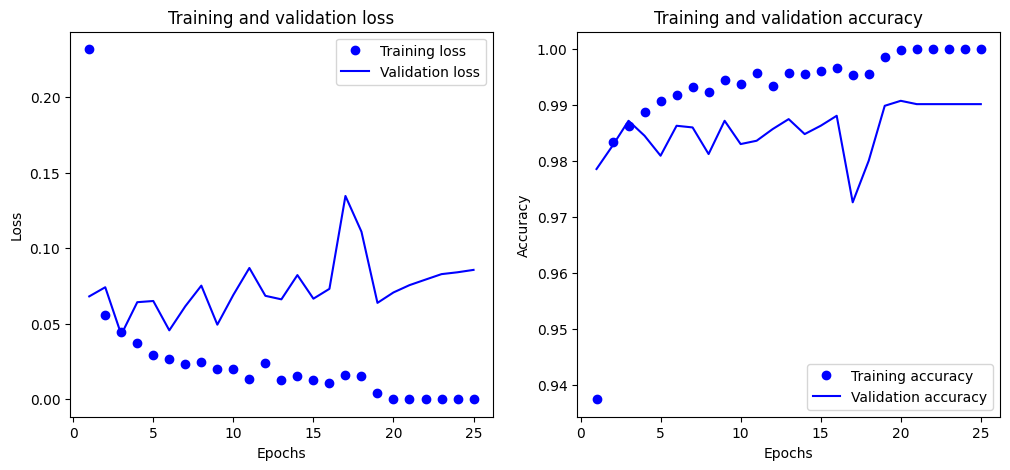

875/875 ━━━━━━━━━━━━━━━━━━━━ 182s 208ms/step
Your submission was successfully saved!
263/263 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.9925 - loss: 0.0441
Test accuracy: 0.9923809766769409


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau

# Načtení dat
data = pd.read_csv("/content/train.csv")
blank_data = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sample_submission.csv")

# Příprava dat
X = data.drop("label", axis=1)
y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Převod na numpy pole
X_train = np.array(X_train)
X_test = np.array(X_test)

# Vizualizace jednoho obrázku
idx = 10
plt.title(y_train.iloc[idx])
plt.imshow(X_train[idx].reshape(28, 28), cmap="gray")
plt.show()

# Definice modelu
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    Conv2D(192, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(192, (3, 3), activation="relu"),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(10, activation="softmax")
])

# Přizpůsobení tvaru dat
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Kompilace modelu
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, verbose=1,
                              patience=2, min_lr=0.00000001)
# Trénování modelu
history = model.fit(X_train, y_train, epochs=25, validation_split=0.1, callbacks=[reduce_lr])

# Grafy ztráty a přesnosti
def plot_history(history):
    epochs = range(1, len(history.history["loss"]) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history["loss"], "bo", label="Training loss")
    plt.plot(epochs, history.history["val_loss"], "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history["accuracy"], "bo", label="Training accuracy")
    plt.plot(epochs, history.history["val_accuracy"], "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

plot_history(history)

# Příprava testovacích dat
blank_data = blank_data.to_numpy().reshape(-1, 28, 28, 1).astype(np.float32)

# Predikce
predictions = model.predict(blank_data)
predictions_1d = predictions.argmax(axis=1)

# Uložení výsledků
output = pd.DataFrame({'ImageId': sample_submission.ImageId, 'Label': predictions_1d})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

# Vyhodnocení CNN
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)